Before we start the VQS approach, use qiskit to run an ideal simulation, to have as a reference.

In [12]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.23.5


In [11]:
import warnings
warnings.simplefilter('ignore')
# progress bar
from tqdm.notebook import tqdm
from tqdm import trange
from time import sleep

In [13]:
# importpackages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

# importing Qiskit
from qiskit import IBMQ, Aer
#from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# IBMQ
#from qiskit import IBMQ

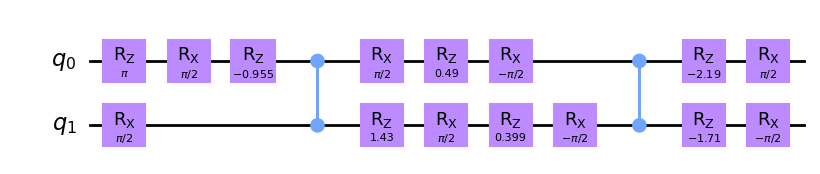

In [14]:
# create quantum register (bundle of qubits)
n=2
qreg_q = QuantumRegister(n, 'q')

# we could add a classical register to record
#creg_c = ClassicalRegister(2, 'c')

# and then add both the quantum and classical to the circuit
#circuit = QuantumCircuit(qreg_q, creg_c)

circuit = QuantumCircuit(qreg_q)

# add individual gates
circuit.rz(pi, qreg_q[0])
circuit.rx(pi/2, qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rz(-0.955316618124509, qreg_q[0])
circuit.cz(qreg_q[0], qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rz(1.427466598294886, qreg_q[1])
circuit.rz(0.489897485566355, qreg_q[0])
circuit.rx(pi/2, qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.rz(0.39864643091, qreg_q[1])
circuit.rx(-pi/2, qreg_q[1])
circuit.cz(qreg_q[0], qreg_q[1])
circuit.rz(-2.186276035465, qreg_q[0])
circuit.rz(-1.714126055294, qreg_q[1])
circuit.rx(pi/2, qreg_q[0])
circuit.rx(-pi/2, qreg_q[1])

# draw
circuit.draw('mpl', filename='circuit.pdf')

# Create circuit

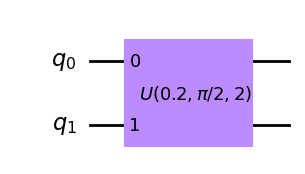

In [15]:
# we can convert the previous circuit to a custom gate
U_shi = circuit.to_gate()
U_shi.label = "$U(0.2,\pi/2,2)$"
# we can then add the new gate to a circuit many times
qc_shi = QuantumCircuit(2)
qc_shi.append(U_shi,[0,1])
qc_shi.draw('mpl')

# Statevector simulation

In [ ]:
# With Statevector we can impose an initial wavefunction
# without having to worry about state preparation
# which is usually non-trivial
psi0 = Statevector.from_label('00')
psi = psi0
tdim = 100
# occupation coefficients
alpha0 = np.zeros(tdim)
alpha1 = np.zeros(tdim)
alpha2 = np.zeros(tdim)
# evolve state in time
for t in range(tdim):
    # run circuit 1 time step
    alpha0[t] = np.abs(psi.data[0])**2
    alpha1[t] = np.abs(psi.data[2])**2
    alpha2[t] = np.abs(psi.data[1])**2
    psi = psi.evolve(qc_shi)

# Variational Quantum Simulation
We now use the PennyLane API (see https://pennylane.readthedocs.io/en/stable/ )

In [17]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from numpy import pi

First we need to define a device. In this case, we will require 2 qubits per wavefunction (times 2) plus an ancilla qubit.

In [18]:
qubits = 2
dev = qml.device('default.qubit', wires=2*qubits+1)

We now define a circuit that returns the occupation levels.

In [38]:
# circuit to get probabilities after each time step
@qml.qnode(dev)
def circuit(params_new):
    # reg1 |psi(t)>
    """
    # universal parameterized 2 qubit circuit (probably a overkill)
    qml.Rot(params[0],params[1],params[2], wires=0)
    qml.Rot(params[3],params[4],params[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Rot(params[0+6],params[1+6],params[2+6], wires=0)
    qml.Rot(params[3+6],params[4+6],params[5+6], wires=1)
    qml.CNOT(wires=[1, 0])
    qml.Rot(params[0+12],params[1+12],params[2+12], wires=0)
    qml.Rot(params[3+12],params[4+12],params[5+12], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Rot(params[0+18],params[1+18],params[2+18], wires=0)
    qml.Rot(params[3+18],params[4+18],params[5+18], wires=1)
    """
    
    # simple ansatz
    qml.RY(params_new[0], wires=0)
    qml.RY(params_new[1], wires=1)
    qml.RZ(params_new[2], wires=0)
    qml.RZ(params_new[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(params_new[4], wires=0)
    qml.RY(params_new[5], wires=1)
    qml.RZ(params_new[6], wires=0)
    qml.RZ(params_new[7], wires=1)
    qml.CNOT(wires=[1,0])
    
    return qml.probs(wires=[0,1])

Here we define the main VQS circuit, where the SWAP test is used to quantify the overlap between wavefunctions.
Comment out the lines to extend the ansatz to 2 blocks.

In [39]:
# circuit to get probabilities after each time step
@qml.qnode(dev)
def circuitSWAP(params_new):
    #params_new = params[:7]
    #params_old = np.random.normal(0, np.pi, (8, ))*0
    
    # reg1 |psi(t)>
    # simple ansatz
    qml.RY(params_new[0], wires=0)
    qml.RY(params_new[1], wires=1)
    qml.RZ(params_new[2], wires=0)
    qml.RZ(params_new[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(params_new[4], wires=0)
    qml.RY(params_new[5], wires=1)
    qml.RZ(params_new[6], wires=0)
    qml.RZ(params_new[7], wires=1)
    qml.CNOT(wires=[1,0])
    
    # reg2 |psi(t+dt)>
    # simple ansatz
    qml.RY(params_old[0], wires=2)
    qml.RY(params_old[1], wires=3)
    qml.RZ(params_old[2], wires=2)
    qml.RZ(params_old[3], wires=3)
    qml.CNOT(wires=[2, 3])
    qml.RY(params_old[4], wires=2)
    qml.RY(params_old[5], wires=3)
    qml.RZ(params_old[6], wires=2)
    qml.RZ(params_old[7], wires=3)
    qml.CNOT(wires=[3,2])
    
    # apply U-operator
    qml.RZ(pi, wires=0)
    qml.RX(pi/2, wires=1)
    qml.RX(pi/2, wires=0)
    qml.RZ(-0.955316618124509, wires=0)
    qml.CZ(wires=[0,1])
    qml.RX(pi/2, wires=0)
    qml.RZ(1.427466598294886, wires=1)
    qml.RZ(0.489897485566355, wires=0)
    qml.RX(pi/2, wires=1)
    qml.RX(-pi/2, wires=0)
    qml.RZ(0.39864643091, wires=1)
    qml.RX(-pi/2, wires=1)
    qml.CZ(wires=[0,1])
    qml.RZ(-2.186276035465, wires=0)
    qml.RZ(-1.714126055294, wires=1)
    qml.RX(pi/2, wires=0)
    qml.RX(-pi/2, wires=1)
    
    # SWAP
    qml.Hadamard(wires=4)
    qml.CSWAP(wires=[4,0,2])
    qml.CSWAP(wires=[4,1,3])
    qml.Hadamard(wires=4)
    
    # return probability
    return qml.expval(qml.PauliZ(4))

Choose initial random parameters.

In [40]:
#np.random.seed(0)
init_params_new = np.random.normal(0, np.pi, (8, ))
init_params_old = np.random.normal(0, np.pi, (8, ))
print(init_params_new,init_params_old)

def cost(x):
    return -1*circuitSWAP(x)
cost(init_params_new)

[ 0.1175938   6.59266428 -3.2878878  -2.0380598   3.72362055 -3.07433265
 -2.30156891 -0.84054473] [-2.60320751  0.12814164  5.06999158  2.16170913 -2.55512707  1.54036329
  2.02940033  6.13551839]


tensor(-0.1001222, requires_grad=True)

We now run VQS for a number of timesteps. The classical algorithm will try to minimize the cost function (for larger and non-ideal simulations, GradientDescentOptimizer might not be optimal).

In [41]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.6)
# set the number of steps
steps = 50

# set the initial parameter values
params_old = init_params_old*0
params_new = init_params_new

alpha0_UH = np.zeros((tdim,1))
alpha1_UH = np.zeros((tdim,1))
alpha2_UH = np.zeros((tdim,1))

for t in trange(tdim):

    for i in range(steps):
        # update the circuit parameters
        params_new = opt.step(cost, params_new)
    """
        if (i + 1) % 3 == 0:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params_new)))
    print("Optimized rotation angles: {}".format(params_new))
    """

    # update old parameters
    params_old = params_new

    # save results
    UHtmp = circuit(params_new).numpy()
    alpha0_UH[t] = UHtmp[0]
    alpha1_UH[t] = UHtmp[1]
    alpha2_UH[t] = UHtmp[2]

100%|█████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


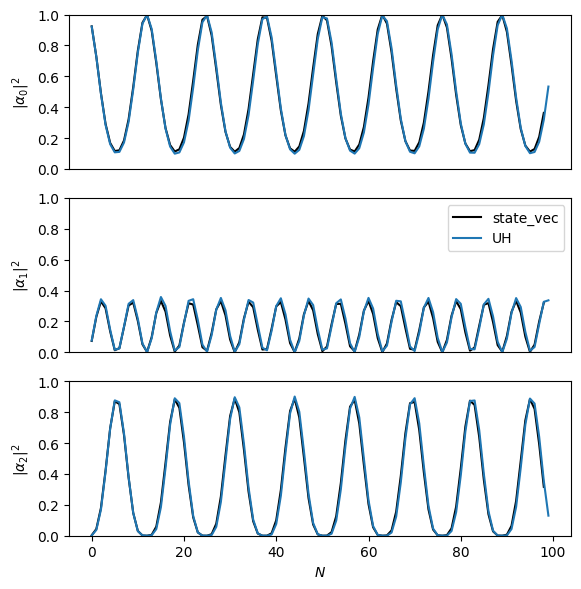

In [42]:
fig, axes= plt.subplots(nrows=3, ncols=2,figsize=(6,6))

plt.subplot(311)
plt.plot(alpha0[1:],'k')
plt.plot(alpha0_UH,'-',color='#1f77b4')
#plt.plot(alpha0_qasm,'o')
#plt.plot(alpha0_ibm,'.')
plt.ylim([0,1])
plt.xticks([])
plt.ylabel(r'$|\alpha_0|^2$')
plt.subplot(312)
plt.plot(alpha1[1:],'k',label='state_vec')
plt.plot(alpha1_UH,'-',color='#1f77b4',label='UH')
#plt.plot(alpha1_qasm,'o',label='qasm shots=300')
#plt.plot(alpha1_ibm,'.',label='ibm shots=300')
plt.ylim([0,1])
plt.xticks([])
plt.legend(loc='best')
plt.ylabel(r'$|\alpha_1|^2$')
plt.subplot(313)
plt.plot(alpha2[1:],'k')
plt.plot(alpha2_UH,'-',color='#1f77b4')
#plt.plot(alpha2_qasm,'o')
#plt.plot(alpha2_ibm,'.')
plt.ylim([0,1])
plt.xlabel(r'$N$')
plt.ylabel(r'$|\alpha_2|^2$')

plt.tight_layout()
plt.savefig('Blocks2.pdf', dpi=400)
plt.show()